<h1>Fitting IVT mechanistic model to new data<h1>

In this notebook, we will be showing how to use fit the model presented in our work to new data. We will demonstrate:
    
    1. Plotting model predictions against data the model has not seen before
    2. Incorporating new data into the fitting process and re-performing parameter estimation
    3. Visualizing model fitting by plotting against new data
    4. Using new parameters for hypothesis testing

<b>1. Importing required packages<b>

In [1]:
using Pkg
Pkg.activate("IVTmodel")
Pkg.instantiate()
using Distributed
using DifferentialEquations
using Plots
using NLopt
using LinearAlgebra
using Metrics
using CSV, DataFrames
using StaticArrays
using ForwardDiff
using NamedTupleTools
using BenchmarkTools
using ComponentArrays
using Distributions
using Statistics
using GenericLinearAlgebra
using DiffResults
using FLoops
using SharedArrays
using Plots.PlotMeasures
using FlexiMaps
using LaTeXStrings
using DelimitedFiles
using StatsBase
using NLsolve

include("./modules/model.jl")
include("./modules/parameterbackend.jl")
include("./modules/akamadataprocessing.jl")
include("./modules/akamaplotting.jl")
include("./modules/IVTplotting.jl")
include("./modules/modelfitting.jl")
include("./modules/residualcalculation.jl")
include("./modules/parameteruncertainty.jl")
include("./modules/predictionuncertainty.jl")
include("./modules/akamasensitivity.jl");

  Activating project at `C:\Users\ChemeGrad2021\Documents\Braatz Group\MRNA Synthesis\Published code\IVTmechanisticmodel\IVTmodel`
Precompiling project...
  ? Metrics
Precompiling Metrics
        Info Given Metrics was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? Metrics
[ Info: Waiting for another process (pid: 79532) to finish precompiling Metrics [cb9f3049-315b-4f05-b90c-a8adaec4da78]. Pidfile: C:\Users\ChemeGrad2021\.julia\compiled\v1.10\Metrics\ieFta_8mZBI.ji.pidfile
[ Info: Precompiling Metrics [cb9f3049-315b-4f05-b90c-a8adaec4da78]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing Metrics [cb9f3049-315b-4f05-b90c-a8adaec4da78].
┌ Warning: Replacing docs for `Metrics.bin_to_cat :: Tuple{Any, An

In [2]:
#Generates settings for parameters used
fittingmodel = setupmodel()
#Imports calibration data from csv files
modeldata = importakamadata()
#Imports PPiase validation data
PPiasedata = importakamaPPiasedata();

<b>2: Importing fitted parameters and covariance matrix from fitting solely on Akama dataset<b>

    We will inport the parameters generated in the other notebook to predict the output of a new dataset. 

In [3]:
akamafittedparametersmatrix = Matrix(CSV.read("outputs/fittedparameters.csv", DataFrame,header=false))
akamafittedparameterslist = reshape(akamafittedparametersmatrix,(size(akamafittedparametersmatrix)[1],))
akamafittedcovariancematrix = Matrix(CSV.read("outputs/covariancematrix.csv", DataFrame,header=false))
akamafittedparams = fullparameterset(fittingmodel,akamafittedparameterslist)
printresidual(fittingmodel,modeldata,akamafittedparameterslist)

Total Residual:                        818.6
Components of residual:
Concentration Trajectories (Figure 2): 333.9
Initial Reaction Rate (Figure 3A):     152.3
Mg2PPi solubility (Figure 3B):         256.6
Parameter priors:                      75.8


<b>3: Plotting Akama fitting against Akama data<b>

   For comparison to later sections of this notebook, shown here is the Akama calibration data with the Akama fit. These are the same figures presented in the main body of our paper. 

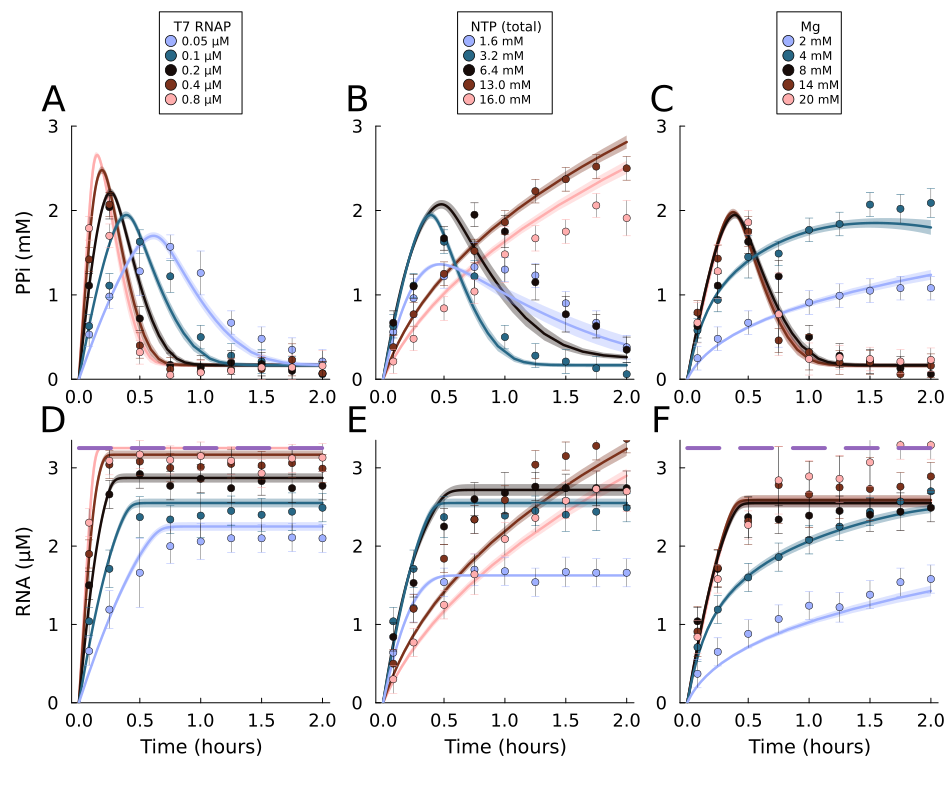

In [4]:
plt = revision1plot1(fittingmodel,modeldata, akamafittedparams, akamafittedcovariancematrix, true,true)

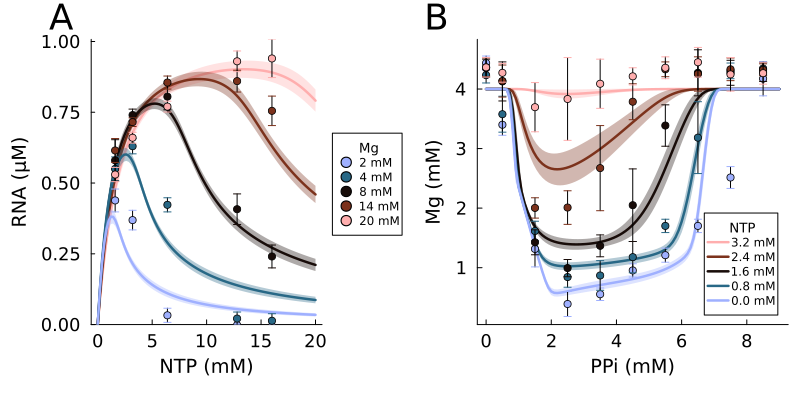

In [5]:
plt = revision1plot2(fittingmodel,modeldata, akamafittedparams, akamafittedcovariancematrix, true,true)

<b>4: Plotting Akama fitting against new data<b>
    
First, we define the file containing our new data. The data we are adding here was collected using initial NTP concentrations of ~25 mM. That is outside of the range our model was calibrated on, meaning that we are extrapolating. Our predictions on this data are incorrect with large uncertainty. 

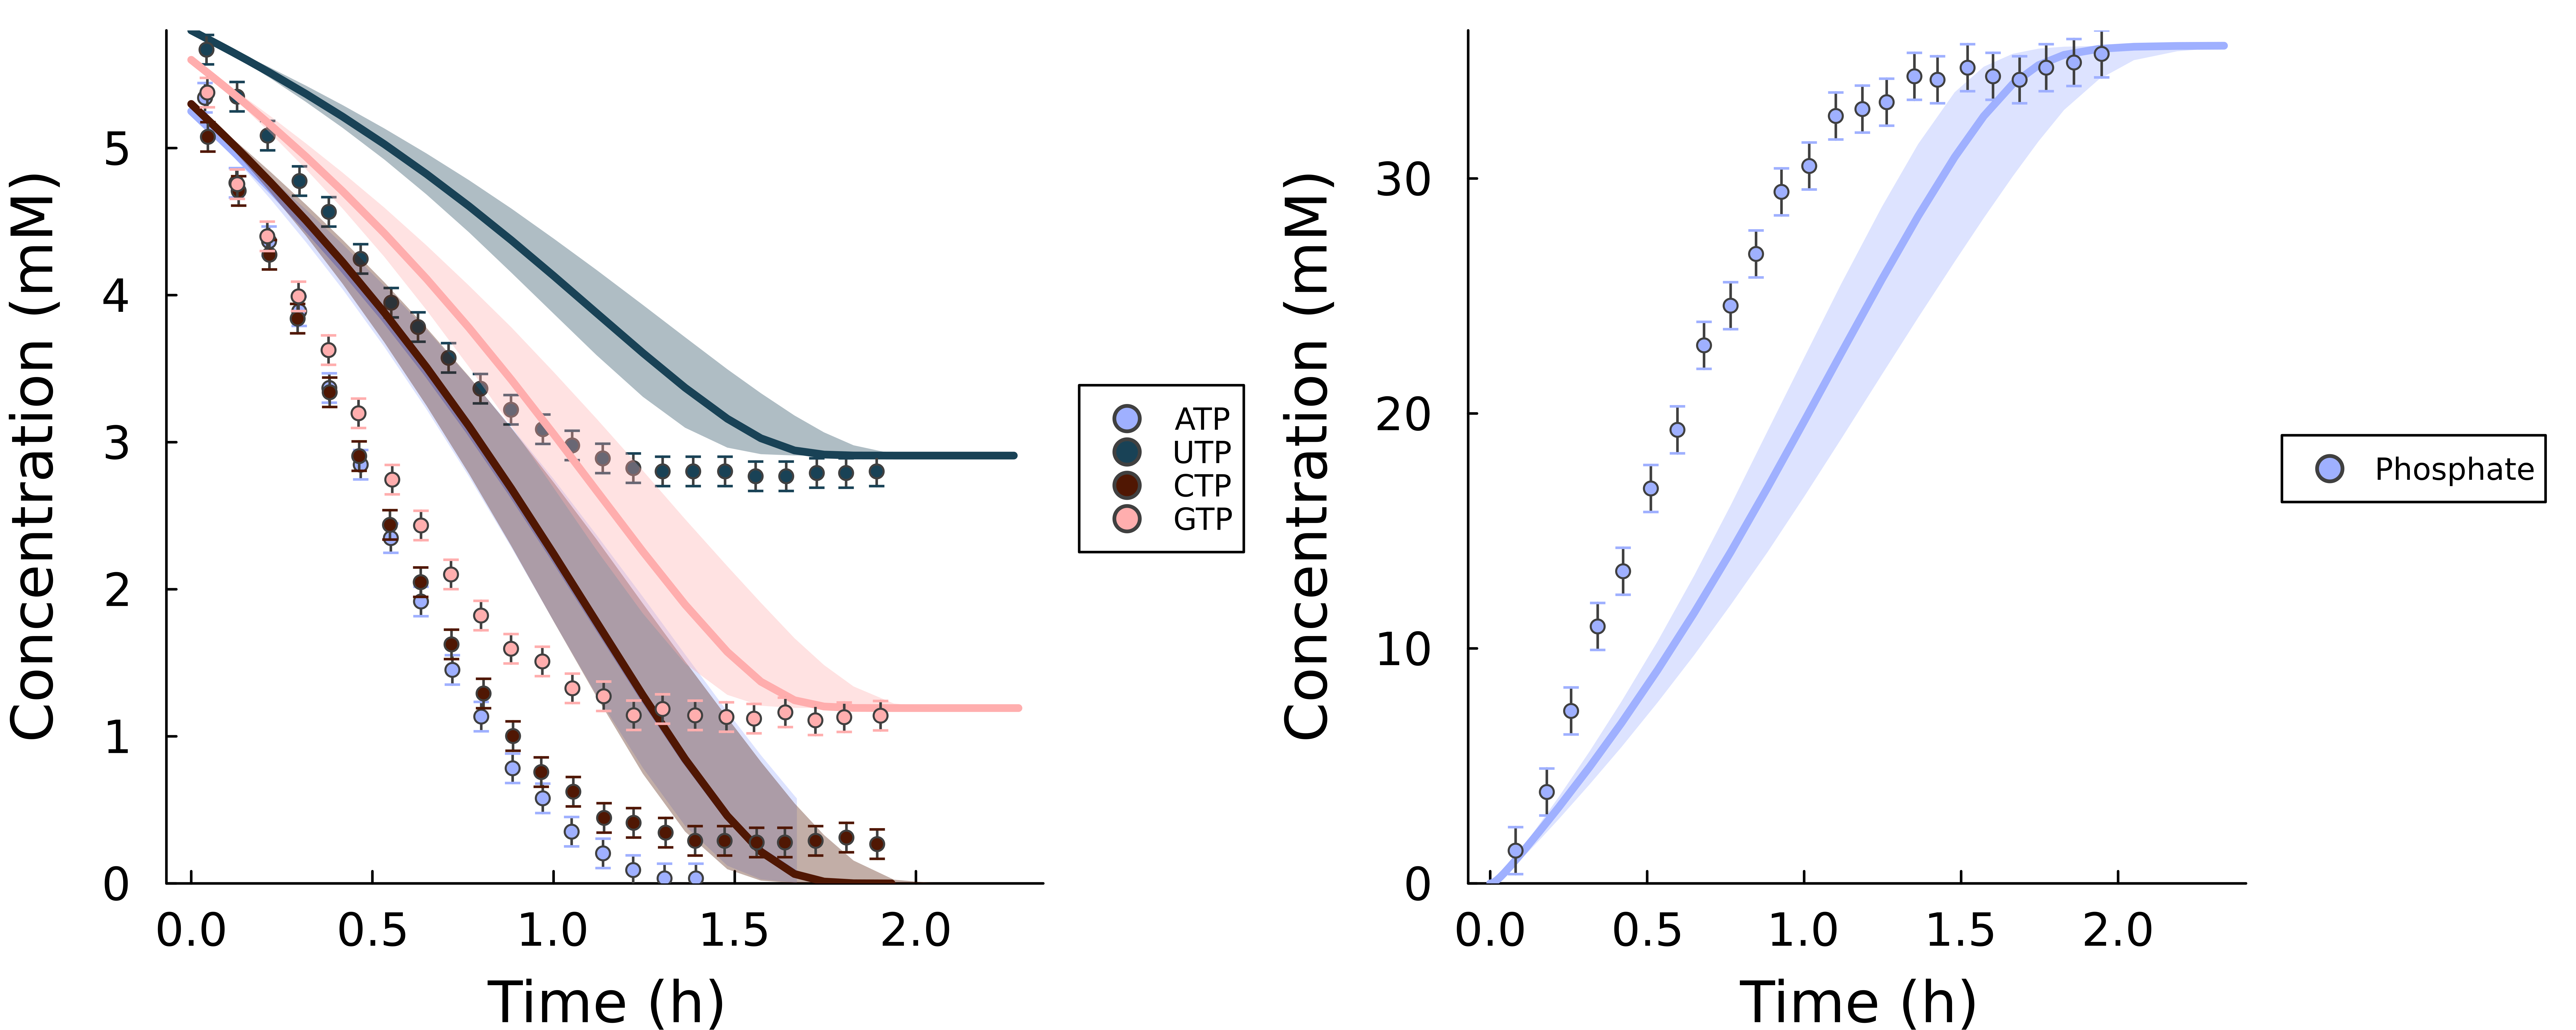

In [6]:
filename = "data/pfizerNTP.csv"
pfizerplot1 = plotfromcsv(fittingmodel,akamafittedparameterslist,akamafittedcovariancematrix,filename, range = 1:4,dataerrorbars = true, maximumyield = false, plotsize = (500,400),labels = ["ATP","UTP","CTP","GTP",], multiplot = false)
pfizerplot2 = plotfromcsv(fittingmodel,akamafittedparameterslist,akamafittedcovariancematrix,filename,range = 5:5,dataerrorbars = true, maximumyield = false, plotsize = (500,400),labels = ["Phosphate","RNA"])
pfizerplotfull1 = plot(pfizerplot1,pfizerplot2, size = (1000,400), leftmargin = 5mm, bottommargin = 5mm,dpi=1000)
savefig(pfizerplotfull1,"figures/pfizerdata_unfitted.png")
pfizerplotfull1

<b>4: Fitting combined Akama + new dataset<b>

We will first evaluate the residual of applying this model to the existing Akama dataset and our new data. Unsuprisingly, the loss associated with our new data is much greater than any other source.

In [7]:
printresidual(fittingmodel,modeldata,akamafittedparameterslist,customfile = true,customfilename = filename)

Total Residual:                        11625.7
Components of residual:
Concentration Trajectories (Figure 2): 333.9
Initial Reaction Rate (Figure 3A):     152.3
Mg2PPi solubility (Figure 3B):         256.6
Parameter priors:                      75.8
Custom Data:                           10807.1


<b>5: Optimizing model with new dataset<b>

In [8]:
res = (model,data,x) -> customresidualeval(model,data,filename,x)
optim=localopt(fittingmodel, modeldata,300,akamafittedparameterslist,res,verbose = true)
customfittedparamslist = optim[4]
customfittedparams = fullparameterset(fittingmodel,customfittedparamslist)
customcovariancemat = getcovariancematrix(fittingmodel,modeldata,customfittedparamslist,customfile = true,customfilename = filename)
writedlm( "outputs/customfittedparameters.csv",  customfittedparamslist, ',')
writedlm( "outputs/customcovariancematrix.csv",  customcovariancemat, ',')


11625.854930996113
67400.84981543246
3890.5511683751597
3199.170789026109
2897.828807220325
2415.447543504886
1896.8339477552759
2438.593843722051
1825.8548999543164
1636.6487301525221
1532.0372980827854
1495.6180778428527
1456.61592631683
1426.0003329791527
1422.5776044922095
1414.6927985807565
1401.8334711505422
1380.576136230423
1360.840390190025
1344.4138696107082
1341.9477841172738
1339.7417236170268
1334.6209495474345
1328.1068647417178
1321.8372586251562
1318.9226409959629
1316.8286945310067
1314.336099623641
1309.77619117479
1302.4072500822388
1292.2788854547146
1281.3373376225406
1274.334317963217
1270.7388464607898
1267.1181611200154
1267.7380471923757
1262.724370482179
1259.7070365763802
1257.1095452778663
1256.1898962183843
1255.2598718964236
1253.2022532115516
1251.3428142459923
1248.1712173744481
1245.1045976805594
1242.591826373828
1241.0377970317384
1238.6284480915324
1237.7910455087972
1236.9469288031737
1236.7493417203555
1236.256426968683
1235.9992754516359
1235.7335

The fitting process has dramatically decreased our overall loss, specifically the loss associated with our new data. 

In [9]:
printresidual(fittingmodel,modeldata,customfittedparamslist,customfile = true,customfilename = filename)

Total Residual:                        1235.0
Components of residual:
Concentration Trajectories (Figure 2): 369.5
Initial Reaction Rate (Figure 3A):     199.3
Mg2PPi solubility (Figure 3B):         246.6
Parameter priors:                      81.6
Custom Data:                           338.0


<b>6: Plotting Figures with new parameter fitting<b>
    
Once we have performed fitting, it is important to check whether our fits to the original data set are reasonable. If the model cannot fit both the original dataset and the new data, it is a sign that the model structure or original data is somehow incongruent with the new data. In this case, the model is able to reasonably fit both the original and new datasets. 

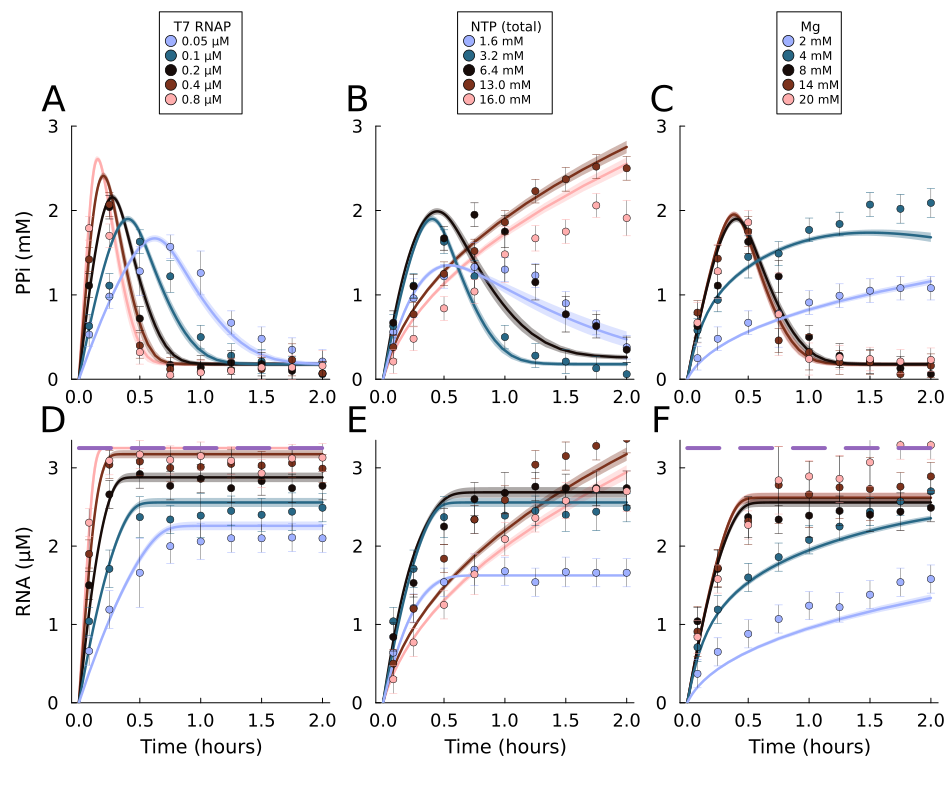

In [10]:
plt = revision1plot1(fittingmodel,modeldata, customfittedparams, customcovariancemat, true,true)

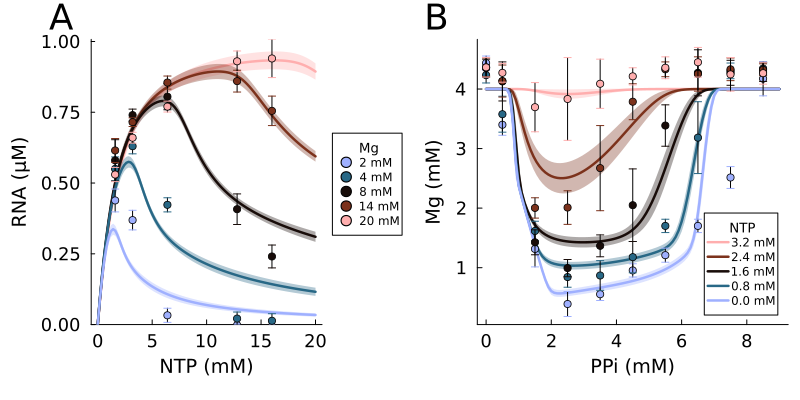

In [11]:
plt = revision1plot2(fittingmodel,modeldata, customfittedparams, customcovariancemat, true,true)

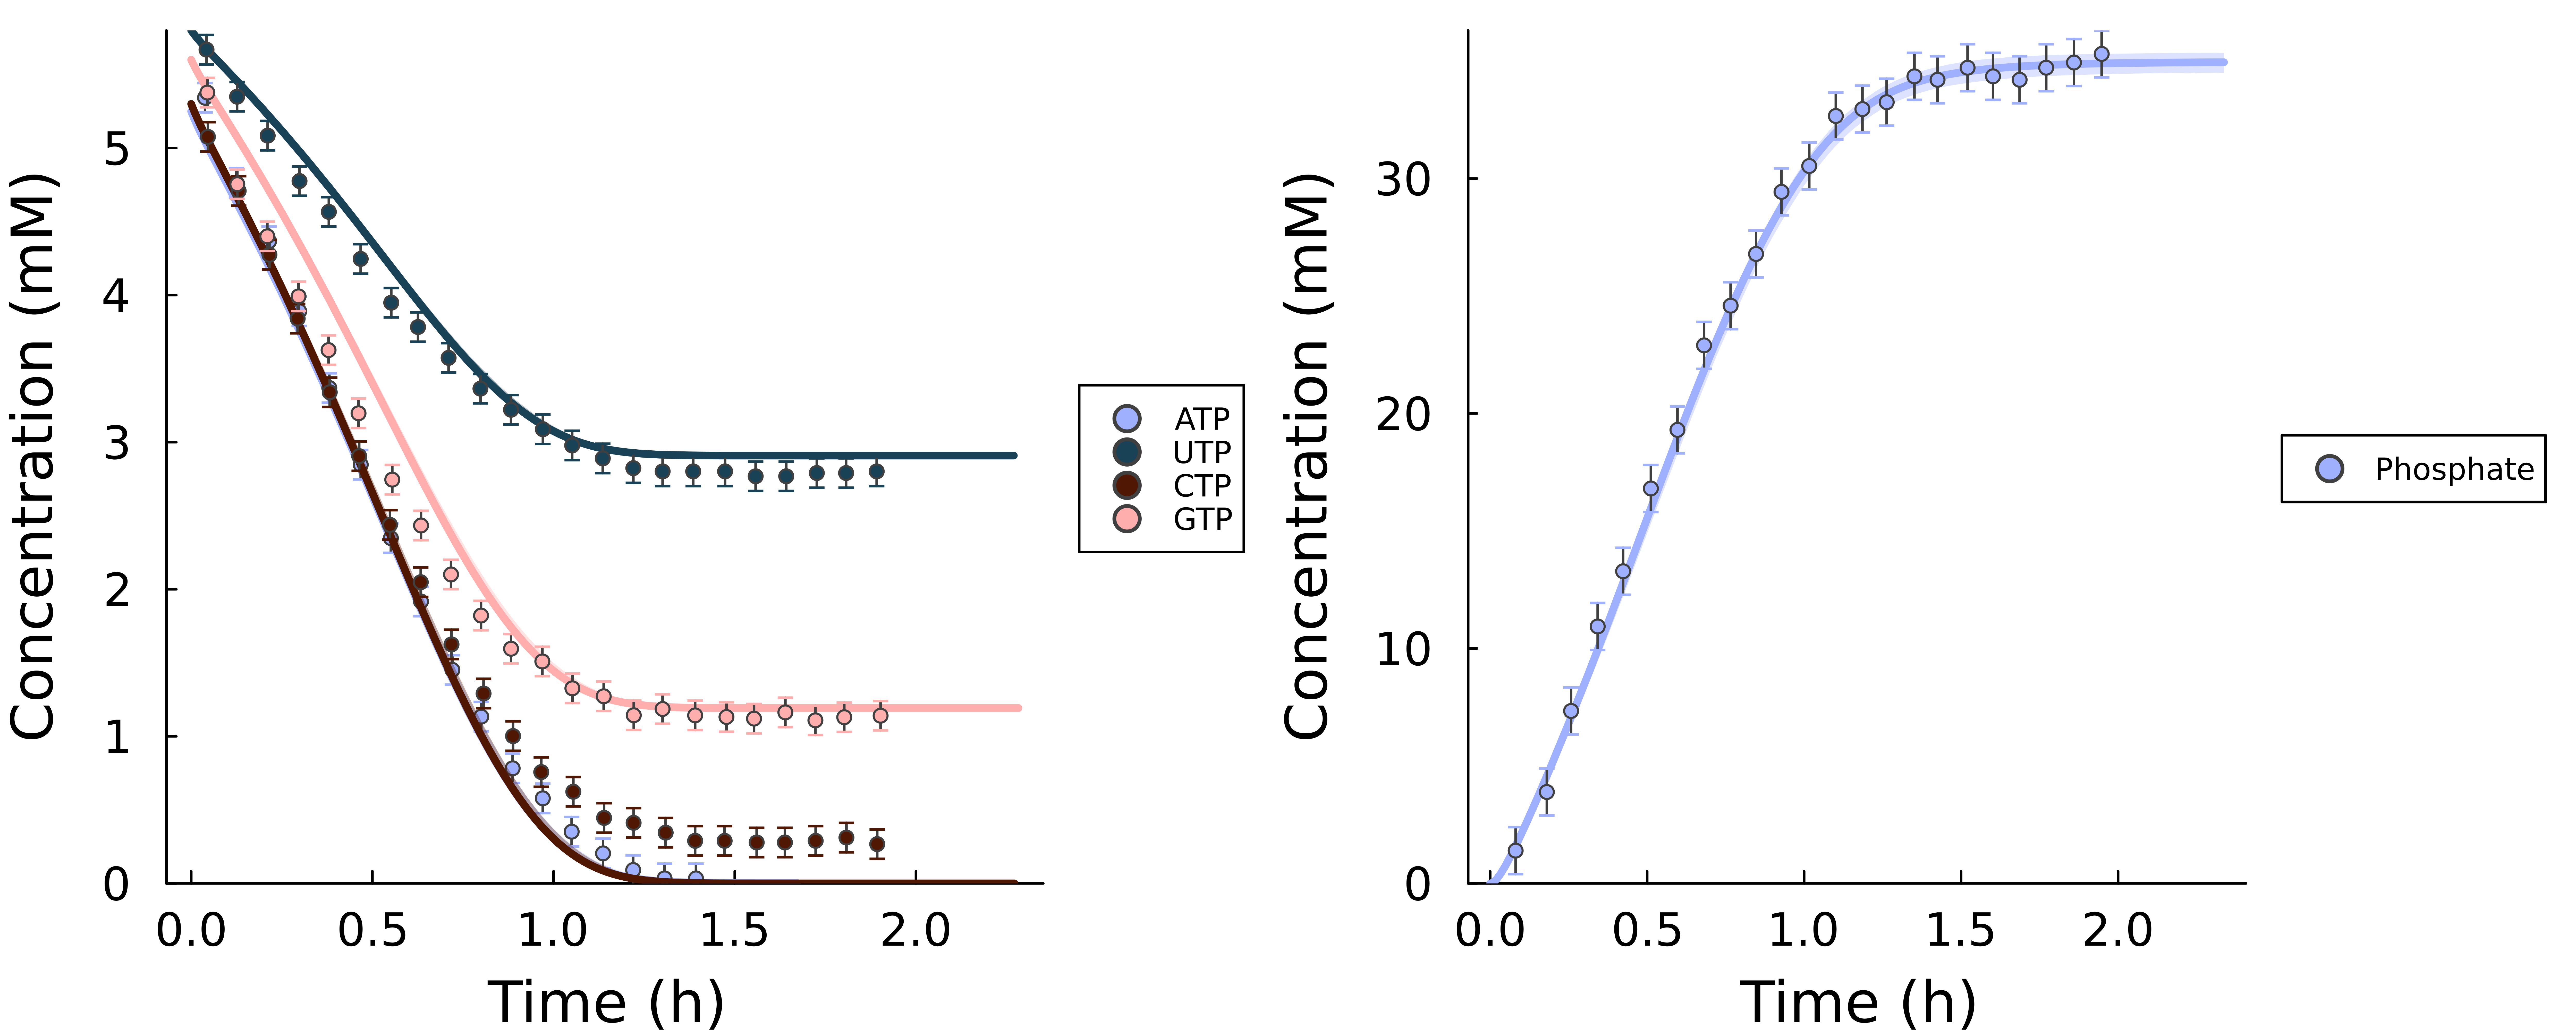

In [12]:
pfizerplot21 = plotfromcsv(fittingmodel,customfittedparamslist, customcovariancemat,"data/pfizerNTP.csv",range = 1:4,dataerrorbars = true, maximumyield = false, plotsize = (800,600),labels = ["ATP","UTP","CTP","GTP",], multiplot = false)
pfizerplot22 = plotfromcsv(fittingmodel,customfittedparamslist, customcovariancemat,"data/pfizerNTP.csv",range = 5:5,dataerrorbars = true, maximumyield = false, plotsize = (500,400),labels = ["Phosphate","RNA"])
pfizerplotfull2 = plot(pfizerplot21,pfizerplot22, size = (1000,400), leftmargin = 5mm, bottommargin = 5mm,dpi=1000)
savefig(pfizerplotfull2,"figures/pfizerdata_fitted.png")
pfizerplotfull2